In [1]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import json
import cv2
import math

from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

Check if CUDA is available

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

2

In [4]:
torch.cuda.empty_cache()

#### load ground truth and pifpaf data:

In [82]:
images_names=os.listdir('data/test/image_2/image_02/data/')
images_names.sort()

In [83]:
labels_names=os.listdir('data/pif_all/')

In [84]:
labels_names.sort()

In [85]:
val_labels=open("val.txt", "r").read().split('\n')

In [88]:
pifpafbox = []
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        with open('data/pif_all/'+label) as inputfile:
            temp = json.load(inputfile)

            if temp != []:
                for person in temp:
                    
                    new=[x/2 for x in person['bbox']]
                    keyp=[x/2 for x in person['keypoints']]
                   
                    confidence=sum(keyp[2::3])/(2*len(keyp[2::3]))
                    del keyp[2::3]

                    new.insert(0,i)
                    new.extend(keyp)
                    new.extend([confidence])

                    pifpafbox.append(new)

print('we have',len(pifpafbox),'pifpaf pedestrians')

we have 4563 pifpaf pedestrians


In [90]:
labels_names=os.listdir('data/training/label_2/')

In [91]:
labels_names.sort()

In [92]:
val_labels=open("val.txt", "r").read().split('\n')

In [93]:
gt = []
positions=[]
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('data/training/label_2/'+label) as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        for line in temp:
            if line[0]=='Pedestrian':
                gt.append([i, float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[-2])])
                positions.append([i,float(line[-4]),float(line[-3])])
print('we have', len(gt),'ground truth pedestrians')

we have 2280 ground truth pedestrians


#### we get the bounding boxes and match them

In [102]:
pifpaf_val_bbox = []
for i in pifpafbox:
    if int(i[0]) in list(map(int, val_labels)):
        pifpaf_val_bbox.append(i)
        

In [103]:
pifpafbox=np.array(pifpaf_val_bbox)

In [104]:
def get_inter_area(r1, r2):
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    return (top-bottom)*(right-left)


In [105]:
def get_union_area(r1, r2):
    return (r1[2]-r1[0])*(r1[3]-r1[1]) + (r2[2]-r2[0])*(r2[3]-r2[1]) - get_inter_area(r1, r2)

In [106]:
gt=np.array(gt)

In [107]:
all_images = list(set(gt[:,0].astype(int)))
final_boxes = []
for i in all_images:
    if len(gt[gt[:,0]==i])==0 or len(pifpafbox[pifpafbox[:,0]==i])==0:
        continue
    inter_matrix = np.zeros((len(gt[gt[:,0]==i]),len(pifpafbox[pifpafbox[:,0]==i])))
    for l, tbbox in enumerate(gt[gt[:,0]==i]):
        for k, mbbox in enumerate(pifpafbox[pifpafbox[:,0]==i]):
            inter_matrix[l,k]=get_inter_area(tbbox[1:5], mbbox[1:])/get_union_area(tbbox[1:5], mbbox[1:])
    for l in range(len(inter_matrix)):
        if inter_matrix[l][np.argmax(inter_matrix[l])]>0.3:
            final_boxes.append(np.append(pifpafbox[pifpafbox[:,0]==i][np.argmax(inter_matrix[l])],gt[gt[:,0]==i][l,-1])) 
            inter_matrix[:,np.argmax(inter_matrix[l])] = 0

In [108]:
print('we have', np.array(final_boxes).shape[0],'matches')

we have 1892 matches


#### we run the monodepth estimation algorithm on all the images

In [109]:
dict_parameters_test = edict({'data_dir':'data/test',
                              'model_path':'data/models/monodepth_resnet18_001.pth',
                              'output_directory':'data/output/',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':True,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

RuntimeError: CUDA error: out of memory

In [18]:
model_test.test()

Finished Testing


#### we load the outputed disparities matrices to estimate the depth

In [20]:
disp = np.load('data/output/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape

(7481, 256, 512)

#### we estimate the depth of pedestrians from the area around the pifpaf keypoints

In [22]:
errors=[]
for box in final_boxes:
    disp_to_img = skimage.transform.resize(disp[int(box[0])].squeeze(), [375, 1242], mode='constant')
    depth = 0.54 * 721 / (1242 * disp_to_img)
    pred = []
    
    for joint in list(zip(box[5:-2][::2],box[5:-2][1::2])):
        
        if (((joint[1]+3)<depth.shape[0]) & ((joint[0]+3)<depth.shape[1])):
            for i in range(3):
                for j in range(3):
                    pred.append(depth[int(joint[1])+i,int(joint[0])+j])
                    pred.append(depth[int(joint[1])-i,int(joint[0])+j])
                    pred.append(depth[int(joint[1])+i,int(joint[0])-j])
                    pred.append(depth[int(joint[1])-i,int(joint[0])-j])
    
    pred=min(pred)
    #pred=sum(pred)/len(pred)
    
        
    gtruth=box[-1]

    errors.append([gtruth,pred,pred-gtruth,int(box[0])])


#### here are some statistics of the results

In [23]:
errors=np.array(errors)
print('average error in m: ', abs(errors[:,2]).mean())

average error in m:  2.8347398789137364


##### error to distance plot

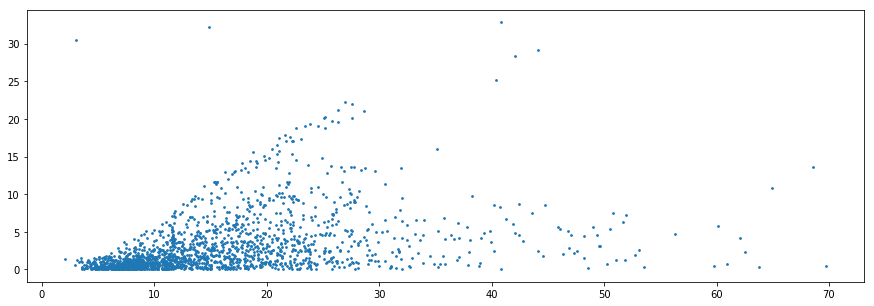

In [80]:
plt.subplots(figsize=(15, 5))
plt.scatter(errors[:,0],abs(errors[:,2]),s=3)
plt.show()

##### error histogram

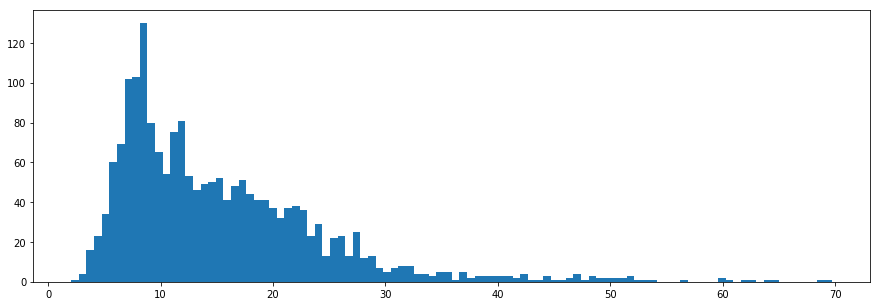

In [79]:
plt.subplots(figsize=(15, 5))
plt.hist(errors[:,0], bins=100)
plt.show()

In [26]:
print('average error in m: ', abs(errors[:,2]).mean())
print('median error in m: ', np.median(abs(errors[:,2])),'\n')

print('smaller than 0.5m: ', len(errors[abs(errors[:,2])<0.5])/len(gt)*100,'%')
print('smaller than 1m: ', len(errors[abs(errors[:,2])<1])/len(gt)*100,'%')
print('smaller than 2m: ', len(errors[abs(errors[:,2])<2])/len(gt)*100,'%\n')

print('the recall is: ', len(errors)*100/len(gt),'%')
print('the rate of false positives is: ',(len(pifpafbox)-len(errors))*100/len(pifpafbox),'%')

average error in m:  2.8347398789137364
median error in m:  1.349913856698338 

smaller than 0.5m:  19.517543859649123 %
smaller than 1m:  34.82456140350877 %
smaller than 2m:  50.13157894736842 %

the recall is:  82.98245614035088 %
the rate of false positives is:  58.536050843743155 %


In [27]:
temp_errors=errors[errors[:,0]<5]
print('average error for gt < 5m :        ', abs(temp_errors[:,2]).mean(),'  median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<10]
temp_errors=temp_errors[temp_errors[:,0]>5]
print('average error for 5m < gt < 10m :  ', abs(temp_errors[:,2]).mean(),' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<15]
temp_errors=temp_errors[temp_errors[:,0]>10]
print('average error for 10m < gt < 15m : ', abs(temp_errors[:,2]).mean(),' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<20]
temp_errors=temp_errors[temp_errors[:,0]>15]
print('average error for 15m < gt < 20m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<25]
temp_errors=temp_errors[temp_errors[:,0]>20]
print('average error for 20m < gt < 25m : ', abs(temp_errors[:,2]).mean(), '  median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]<30]
temp_errors=temp_errors[temp_errors[:,0]>25]
print('average error for 25m < gt < 30m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
temp_errors=errors[errors[:,0]>30]
print('average error for gt > 30m :       ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))



average error for gt < 5m :         1.1555493657630413   median error:  0.4751461986558807
average error for 5m < gt < 10m :   0.8407187818151444  median error:  0.6126666018048503
average error for 10m < gt < 15m :  2.319309889501048  median error:  1.585322004693153
average error for 15m < gt < 20m :  3.979730271567612  median error:  2.878090744258988
average error for 20m < gt < 25m :  5.149849656587735   median error:  3.5171295098818085
average error for 25m < gt < 30m :  6.241845951860494  median error:  4.6308452218185145
average error for gt > 30m :        4.851431059705644  median error:  3.9765812954045394


In [28]:
temp_errors=errors[errors[:,0]<20]
print('average error for gt < 20m : ', abs(temp_errors[:,2]).mean(), ' median error: ', np.median(abs(temp_errors[:,2])))
print('smaller than 0.5m: ', len(temp_errors[abs(temp_errors[:,2])<0.5])/len(temp_errors)*100,'%')
print('smaller than 1m: ', len(temp_errors[abs(temp_errors[:,2])<1])/len(temp_errors)*100,'%')
print('smaller than 2m: ', len(temp_errors[abs(temp_errors[:,2])<2])/len(temp_errors)*100,'%')

average error for gt < 20m :  2.024382322223353  median error:  1.023145990775216
smaller than 0.5m:  28.401953942777393 %
smaller than 1m:  49.546406140963015 %
smaller than 2m:  70.13258897418004 %


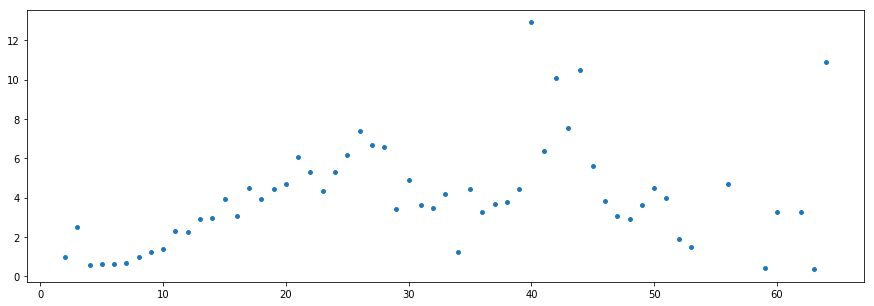

In [78]:
plt.subplots(figsize=(15, 5))
mean_errors=[]
x_errors=[]
for i in range(int(min(errors[:,0])), int(max(errors[:,0]))-3):
    temp_errors=errors[errors[:,0]<i+1]
    temp_errors=temp_errors[temp_errors[:,0]>i]
    if temp_errors.any()!=0:
        mean_errors.append(abs(temp_errors[:,2]).mean())
        x_errors.append(i)
plt.scatter(x_errors,mean_errors,s=15)
plt.show()

In [30]:
np.corrcoef(x=x_errors,y=mean_errors)

array([[1.        , 0.30968335],
       [0.30968335, 1.        ]])

#### store estimation in txt files:

In [37]:
for label in val_labels:
    f= open("data/final-pifpaf/"+label+".txt","w+")
    for i, box in enumerate(all_boxes[all_boxes[:,0]==int(label)]):
        distance=0
        for item in box[1:5]:
            f.write(str(item))
            f.write(', ')
        f.write(str(box[-2]))
        f.write(', ')

        for item in positions[positions[:,0]==int(label)][i][1:]:
            distance+=item**2
        distance+=errors[errors[:,-1]==int(label)][i][1]**2
        f.write(str(math.sqrt(distance)))
        f.write('\n')
    f.close()

#### example of an image

real distance is 9.846375880501794
estimated distance is 11.18
error is -1.3336241194982055


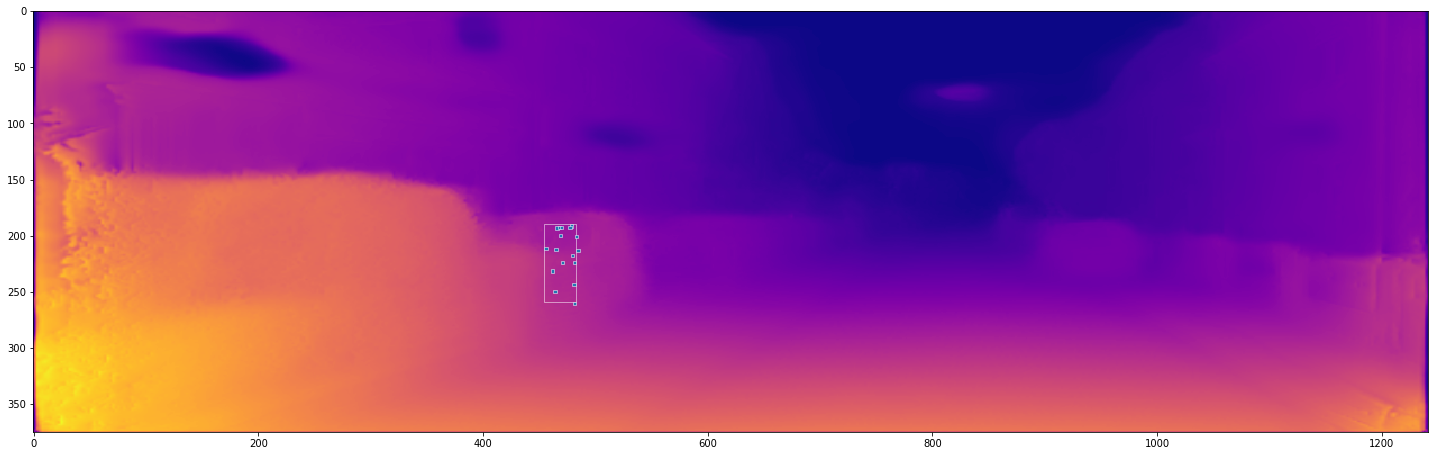

In [73]:
fig,ax = plt.subplots(figsize=(25, 10))

image_id=2048
disp_to_img = skimage.transform.resize(disp[image_id].squeeze(), [375, 1242], mode='constant')
ax.imshow(disp_to_img, cmap='plasma')

disp_bbox = np.array(final_boxes)[np.array(final_boxes)[:,0]==image_id]
disp_bbox=list(disp_bbox[0])
ax.add_patch(
            plt.Rectangle((disp_bbox[0+1], disp_bbox[1+1]),
                          disp_bbox[2+1] - disp_bbox[0+1],
                          disp_bbox[3+1] - disp_bbox[1+1],
                          fill=False, edgecolor='white',
                          linewidth=0.5, alpha=1))
depth = 0.54 * 721 / (1242 * disp_to_img)

print('real distance is', errors[errors[:,-1]==image_id][0][1])

for joint in list(zip(disp_bbox[5:-1][::2],disp_bbox[5:-1][1::2])):
    if ((joint[1]<depth.shape[0]) & (joint[0]<depth.shape[1])):
        ax.add_patch(
            plt.Rectangle(joint,
                          3,
                          3,
                          fill=True, edgecolor='white',
                          linewidth=0.5, alpha=1))

print('estimated distance is',disp_bbox[-1])    
print('error is', errors[errors[:,-1]==image_id][0][2])
plt.show()

In [66]:
from IPython.display import Image

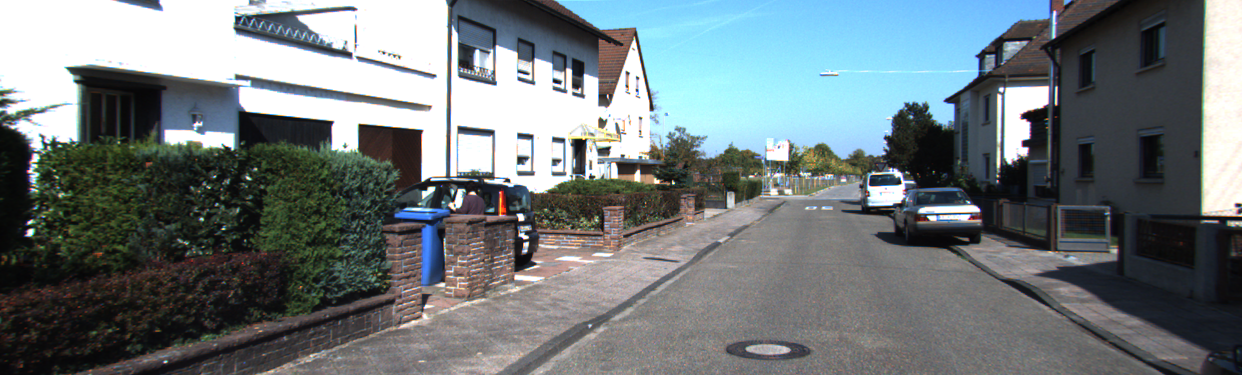

In [67]:
Image(filename = 'data/test/image_2/image_02/data/002048.png')